# Notebook for the ENS Challenge Data 2022 - Qube Research & Technologies 

# **Learning factors for stock market returns prediction**

### Data preparation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

path = './' 

X_train = pd.read_csv(path+'X_train.csv', index_col=0, sep=',')
X_train.columns.name = 'date'

Y_train = pd.read_csv(path+'Y_train.csv', index_col=0, sep=',')
Y_train.columns.name = 'date'

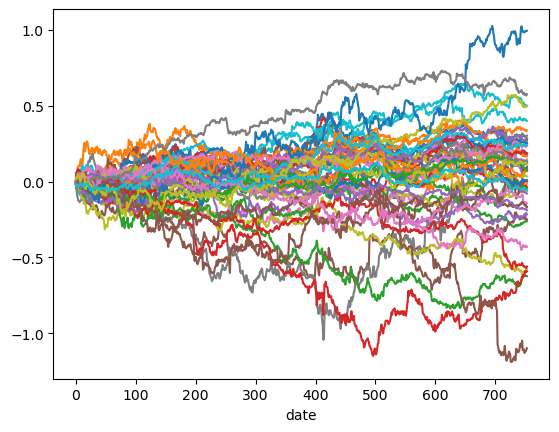

In [2]:
# The cumulative returns of the 50 stocks from the training data set over the three year period 

X_train.T.cumsum().plot(legend=False)
plt.show()

##### A useful data representation:

To speed up upcoming computations, we reshape the data  into a DataFrame with index (date, stock) and columns the lagged return values of the stock at time "date-1, ..., date-250".

In [3]:
X_train_reshape = pd.concat([ X_train.T.shift(i+1).stack(dropna=False) for i in range(250) ], axis=1).dropna()
X_train_reshape.columns = pd.Index(range(1,251), name='timeLag')

C:\Users\netes\AppData\Local\Temp\ipykernel_14580\2263344912.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  X_train_reshape = pd.concat([ X_train.T.shift(i+1).stack(dropna=False) for i in range(250) ], axis=1).dropna()
C:\Users\netes\AppData\Local\Temp\ipykernel_14580\2263344912.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  X_train_reshape = pd.concat([ X_train.T.shift(i+1).stack(dropna=False) for i in range(250) ], axis=1).dropna()
C:\Users\netes\AppData\Local\Temp\ipykernel_14580\2263344912.py:1: FutureWarning: The previous implementation of stack is deprec

In [4]:
X_train_reshape.shape

(25200, 250)

The motivation is that, given model parameters 'A' and 'beta', the associated predictions for Y_train are simply given by **Ypred = ( X_train_reshape @ A @ beta ).unstack().T**

# The prediction model

## Stiefel matrices

##### Example 1: autoregressive model AR(F)

In [5]:
def autoRegA(D=250, F=10):
    
    A = np.zeros((D,F))
    for i in range(F): 
        A[i,i] = 1
    
    return A

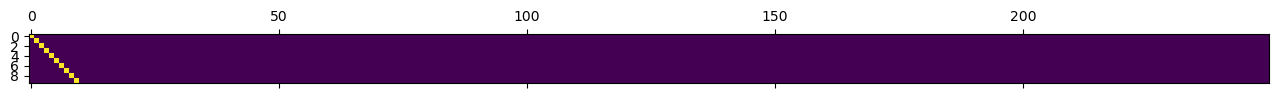

In [6]:
A = autoRegA()
plt.matshow(A.T)
plt.show()

##### Example 2: uniformly random Stiefel matrix A

In [7]:
def randomA(D=250, F=10):  
    
    M = np.random.randn(D,F)
    randomStiefel = np.linalg.qr(M)[0] # Apply Gram-Schmidt algorithm to the columns of M
    
    return randomStiefel

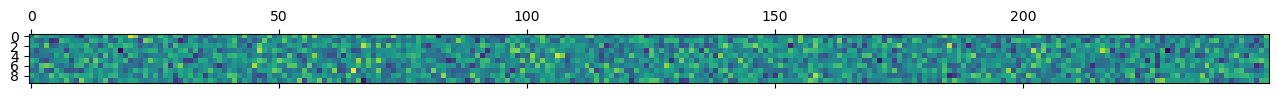

In [8]:
A = randomA()
plt.matshow(A.T)
plt.show()

In [9]:
# to check the orthonormality constraints as in the metric:
    
def checkOrthonormality(A): 
    
    bool = True
    D, F = A.shape   
    Error = pd.DataFrame(A.T @ A - np.eye(F)).abs()
    
    if any(Error.unstack() > 1e-6):
        bool = False
     
    return bool

In [10]:
checkOrthonormality(A)

True

## Beta parameters

##### Example 1: "keep the $m$ first factor only" 

In [11]:
def firstBeta(m=1, F=10):

    beta = np.zeros(F)
    beta[:m] = 1
    
    return beta

##### Example 2: given a Stiefel matrix A, return the beta with minimal mean square prediction error on the training data set

In [12]:
def fitBeta(A):
    
    predictors = X_train_reshape @ A # the dataframe of the 10 factors created from A with the (date, stock) in index
    targets = Y_train.T.stack()
    beta = np.linalg.inv(predictors.T @ predictors) @ predictors.T @ targets
    
    return beta.to_numpy()

## Metric on the training data set

The function **metric_train** below computes the *in sample* version of the metric for parameters 'A' and 'beta', using the accessible data sets 'X_train' and 'Y_train'. 

The true metric of the challenge is defined the same way except that we use the hidden data sets 'X_test' and 'Y_test' instead of 'X_train' and 'Y_train' (recall the latter contain the returns of 50 *other* stocks from the same stock market and on the *same* time period). 

In [13]:
def metric_train(A, beta): 
    
    if not checkOrthonormality(A):
        return -1.0    
    
    Ypred = (X_train_reshape @ A @ beta).unstack().T         
    Ytrue = Y_train
    
    Ytrue = Ytrue.div(np.sqrt((Ytrue**2).sum()), 1)    
    Ypred = Ypred.div(np.sqrt((Ypred**2).sum()), 1)

    meanOverlap = (Ytrue * Ypred).sum().mean()

    return  meanOverlap  

# Examples

##### Test 1: The autoregressive model AR(10)
$$
S_{t+1} := \sum_{\ell=1}^{10} \beta_\ell R_{t+1-\ell}
$$
where the $\beta_\ell$'s are fitted by minimizing the mean square prediction error on the training data set. 

In [14]:
A = autoRegA()
beta = fitBeta(A)

metric_train(A, beta) # public metric: 0.01282

np.float64(0.024027990946887595)

##### Test 2: The two factor model using '5-day returns' and 'momentum'
This model is suggested in the description of the challenge and reads
$$
S_{t+1} := \beta_1 \,R_t^{(5)} + \beta_2 \,R_{t-20}^{(230)},\qquad \text{ with }\quad R_t^{(m)}:= \frac1{\sqrt{m}}\sum_{k=1}^{m} R_{t+1-k},
$$
where we find the parameters $\beta_1$ and $\beta_2$ by minimizing the mean square prediction error on the training data set.  

*NB: the construction below actually shows how a model with $F\leq 10$ factors be recasted into the framework of the challenge.*

In [15]:
A = np.zeros((250,10))
A[0:5, 0] = -0.00694934/np.sqrt(5)
A[20:250, 0] = 0.01560642/np.sqrt(230)
A[np.arange(5, 14), np.arange(1, 10)] = np.ones(9)

norm = np.sqrt(np.sum(A[:, 0]**2))
A[:, 0] /= norm

beta = np.zeros(10)
beta[0] = norm

In [16]:
A = np.zeros((250,10))
A[np.arange(5), np.arange(5)] = 1
A[np.arange(20, 24), np.arange(5, 9)] = 1
A[24:250, 9] = 0.01560642/np.sqrt(230)

norm = np.sqrt(np.sum(A[:, 9]**2))
A[:, 9] /= norm

beta = np.zeros(10)
beta[0:5] = -0.00694934/np.sqrt(5)
beta[5:9] = 0.01560642/np.sqrt(230)
beta[9] = norm

In [17]:
metric_train(A, beta)

np.float64(0.019538512753470804)

In [18]:
# Step 1: Create a 250x10 matrix A with the two first columns representing the factors of interest

A = np.zeros((250,10))

A[0:5, 0] = 1/np.sqrt(5) # 5-day return factor
A[20:250, 1] = 1/np.sqrt(230) # momentum factor

# Step 2: Fill the remaining columns of A with random orthonormal vectors, that are orthogonal to the two first columns

orthoProj = np.eye(250) - np.outer(A[:, 0], A[:, 0]) - np.outer(A[:, 1], A[:, 1]) # projection matrix on the orthogonal to the span of A[:,0] and A[:,1]
A_remaining_columns = orthoProj @ np.random.randn(250, 8) # sample random vectors in the space orthogonal to the first two columns of A
A_remaining_columns = np.linalg.qr(A_remaining_columns)[0] # orthonormalize these vectors with Gram-Schmidt algorithm
A[:, 2:] = A_remaining_columns

# Step 3: Compute the mean square optimal beta_1, beta_2 and then complete the vector beta with zeros

predictors = X_train_reshape @ A[:, :2]
targets = Y_train.T.stack()
beta = np.linalg.inv(predictors.T @ predictors) @ predictors.T @ targets
beta = np.hstack([beta, np.zeros(8)])

print(beta)

metric_train(A, beta) # public metric: 0.01787

[-0.00694934  0.01560642  0.          0.          0.          0.
  0.          0.          0.          0.        ]


np.float64(0.019538512062321104)

# The benchmark

This the code for the benchmark provided in the challenge description. 

In [19]:
Niter = 1000
maxMetric = -1

np.random.seed(1234)

for iteration in range(Niter):
    
    # Generate a uniform random Stiefel matric A and fit beta with minimal mean square prediction error on the training data set
    
    A = randomA()
    beta = fitBeta(A)
    
    # compute the metric on the training set and keep the best result   
    
    m = metric_train(A, beta)
        
    if m > maxMetric:
        print(iteration, 'metric_train:', m)
        
        maxMetric = m
        A_QRT = A
        beta_QRT = beta  

0 metric_train: 0.023313469330359764
1 metric_train: 0.03319696206337412
3 metric_train: 0.035302048607635694
7 metric_train: 0.03999544914662606
67 metric_train: 0.04359368936926119
138 metric_train: 0.044332621329282895
496 metric_train: 0.04441416345796451
675 metric_train: 0.045787821873291355


In [20]:
metric_train(A_QRT, beta_QRT) # public metric: 0.03535

np.float64(0.045787821873291355)

# Postprocessing

## From $(A, \beta)$ to the output csv format

In [21]:
def parametersTransform(A, beta, D=250, F=10):
    
    if A.shape != (D, F):
        print('A has not the good shape')
        return
    
    if beta.shape[0] != F:
        print('beta has not the good shape')
        return        
    
    output = np.hstack( (np.hstack([A.T, beta.reshape((F, 1))])).T )
    
    return output

In [22]:
# random submission example
np.random.seed(1234)

A = randomA()
beta = np.random.rand(10)

# from output to csv file...
output = parametersTransform(A, beta)
pd.DataFrame(output).to_csv(path + 'submissionExample.csv')

# ... and back
output_fromCsv = pd.read_csv(path + 'submissionExample.csv', index_col=0, sep=',').to_numpy()
A = output_fromCsv[:-10].reshape((250, 10))
beta = output_fromCsv[-10:].reshape((10))